# Forecasting with statistical models


Statistical models such as [ARIMA](./forecasting-sarimax-arima.html), [SARIMAX](./forecasting-sarimax-arima.html), and [Exponential Smoothing](./forecasting-ets.html) have served as the backbone of time series analysis for decades. While machine learning models typically frame forecasting as a tabular regression problem (mapping $X$ to $y$), statistical models are designed to explicitly capture the underlying stochastic processes of a series, including stationarity, seasonality, and autocorrelation

Integrating these traditional methods into the forecasting workflow offers several key advantages:

+ Robustness with limited data: Statistical methods often outperform machine learning when historical data is scarce or when the series exhibits a highly stable, dominant seasonal pattern.

+ Interpretability and simplicity: With fewer parameters and well-understood linear relationships, these models are often easier to explain to stakeholders than "black-box" ensembles.

+ Rigorous benchmarking: They provide a critical baseline. Before deploying a complex Gradient Boosting Machine (GBM), it is essential to verify if the added complexity provides significant value over a simpler, traditional approach.

+ Probabilistic foundations: Many statistical models are inherently probabilistic, providing reliable confidence intervals and uncertainty quantification natively.

One of the primary challenges in the Python ecosystem is that statistical libraries often lack a unified API. Unlike the scikit-learn ecosystem, each library typically follows its own convention, making it difficult to switch between models or integrate them into a standardized pipeline. **skforecast** bridges this gap in two ways:

+ Native scikit-learn compatible implementations: provide efficient implementations of [`Arima`, `Auto Arima`, `SarimaX`](../api/stats.html#skforecast.stats._arima.Arima), [`ETS`, `Auto Ets`](../api/stats.html#skforecast.stats._ets.Ets), and [`ARAR`](../api/stats.html#skforecast.stats._arar.Arar) models that strictly follow the scikit-learn API.

+ The [`ForecasterStats`](../api/forecasterstats.html) class: This specialized class acts as a wrapper, allowing the use of one or multiple statistical models while leveraging the full power of the skforecast ecosystem including: backtesting, hyperparameter search, and exogenous variable integration. In addition to the native implementations, ForecasterStats is compatible with other libraries such as statsmodels, sktime and aeon.

<div class="admonition note" name="html-admonition" style="background: rgba(0,191,191,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00bfa5; border-color: #00bfa5; padding-left: 10px; padding-right: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#00bfa5;"></i>
    <b style="color: #00bfa5;">&#128161 Tip</b>
</p>

<p>
To learn more about modeling time series with statistical models, visit our examples:

<ul>
    <li><a href="https://www.cienciadedatos.net/documentos/py51-arima-sarimax-models-python.html">ARIMA and SARIMAX models with Python</a></li>
    <li><a href="https://cienciadedatos.net/documentos/py73-arar-forecasting-models-python">ARAR models with Python</a></li>
    <li><a href="https://cienciadedatos.net/documentos/py76-exponential-smoothing-models">ETS models with Python</a></li>
    <li><a href="../faq/benchmark-statistical-models.html">Benchmark of statistical models for forecasting</a></li>
</ul>
</p>
</div>

The following sections focus on how to use ForecasterStats to train an ARIMA model and predict future values.

## ForecasterStats

The [`ForecasterStats`](../api/forecasterstats.html) class allows for the training and validation of statistical models using the skforecast API. It is compatible with several statistical models from diferent libraries:

+ **skforecast** [Arima, Auto Arima, Sarimax](../api/stats.html#skforecast.stats._arima.Arima), [Ets, Auto Ets](../api/stats.html#skforecast.stats._ets.Ets)

+ **statsmodels** [Sarimax](../api/stats.html#skforecast.stats._sarimax.Sarimax)

+ **sktime** [ARIMA](https://www.sktime.net/en/stable/api_reference/auto_generated/sktime.forecasting.arima.ARIMA.html)

+ **Aeon** [ARIMA](https://www.aeon-toolkit.org/en/stable/api_reference/auto_generated/aeon.forecasting.stats.ARIMA.html#arima)

<div class="admonition note" name="html-admonition" style="background: rgba(255,145,0,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #ff9100; border-color: #ff9100; padding-left: 10px; padding-right: 10px">

<p class="title">
    <i style="font-size: 18px; color:#ff9100; border-color: #ff1744;"></i>
    <b style="color: #ff9100;"> <span style="color: #ff9100;">&#9888;</span> Warning</b>
</p>

<p>
Since version <b>0.19.0</b> of skforecast, the class <code>ForecasterSarimax</code> has been deprecated in favor of the new class <code>ForecasterStats</code>, which provides improved performance and broader compatibility with statistical models. Users are encouraged to transition to <code>ForecasterStats</code> for future projects.

</p>
</div>

## Libraries and data

In [62]:
# Libraries
# ==============================================================================
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from skforecast.datasets import fetch_dataset
from skforecast.stats import Arima, Ets, Arar
from skforecast.recursive import ForecasterStats
from skforecast.model_selection import TimeSeriesFold, backtesting_stats, grid_search_stats
from skforecast.plot import set_dark_theme, plot_prediction_intervals
import warnings
warnings.filterwarnings('once')

In [63]:
# Download data
# ==============================================================================
data = fetch_dataset(name='fuel_consumption', raw=False)
data = data.loc[:'1990-01-01 00:00:00', 'Gasolinas']
data.name = 'y'
data

╭──────────────────────────────── fuel_consumption ────────────────────────────────╮
│ Description:                                                                     │
│ Monthly fuel consumption in Spain from 1969-01-01 to 2022-08-01.                 │
│                                                                                  │
│ Source:                                                                          │
│ Obtained from Corporación de Reservas Estratégicas de Productos Petrolíferos and │
│ Corporación de Derecho Público tutelada por el Ministerio para la Transición     │
│ Ecológica y el Reto Demográfico. https://www.cores.es/es/estadisticas            │
│                                                                                  │
│ URL:                                                                             │
│ https://raw.githubusercontent.com/skforecast/skforecast-                         │
│ datasets/main/data/consumos-combustibles-mensual.csv                             │
│                                                                                  │
│ Shape: 644 rows x 5 columns                                                      │
╰──────────────────────────────────────────────────────────────────────────────────╯

Fecha
1969-01-01    166875.2129
1969-02-01    155466.8105
1969-03-01    184983.6699
1969-04-01    202319.8164
1969-05-01    206259.1523
                 ...     
1989-09-01    687649.2852
1989-10-01    669889.1602
1989-11-01    601413.8867
1989-12-01    663568.1055
1990-01-01    610241.2461
Freq: MS, Name: y, Length: 253, dtype: float64

Train dates : 1969-01-01 00:00:00 --- 1980-01-01 00:00:00  (n=133)
Test dates  : 1980-02-01 00:00:00 --- 1990-01-01 00:00:00  (n=120)


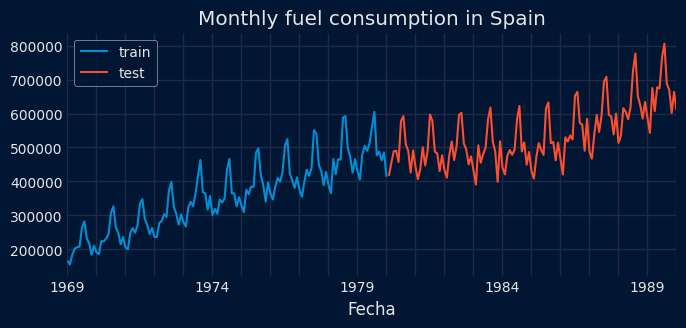

In [64]:
# Split data in train-test partitions
# ======================================================================================
set_dark_theme()
end_train = '1980-01-01 23:59:59'
print(
    f"Train dates : {data.index.min()} --- {data.loc[:end_train].index.max()}  "
    f"(n={len(data.loc[:end_train])})"
)
print(
    f"Test dates  : {data.loc[end_train:].index.min()} --- {data.loc[:].index.max()}  "
    f"(n={len(data.loc[end_train:])})"
)
data_train = data.loc[:end_train]
data_test  = data.loc[end_train:]

# Plot
# ======================================================================================
fig, ax = plt.subplots(figsize=(7, 3))
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
ax.set_title('Monthly fuel consumption in Spain')
ax.legend();

## Training

An ARIMA model is uased as estimator within a [`ForecasterStats`](../api/forecasterstats.html) object. This encapsulation harmonizes the intricacies of the model and allows for the coherent use of skforecast's extensive capabilities.

<div class="admonition note" name="html-admonition" style="background: rgba(0,191,191,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00bfa5; border-color: #00bfa5; padding-left: 10px; padding-right: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#00bfa5;"></i>
    <b style="color: #00bfa5;">&#128161 Tip</b>
</p>

<p>
Skforecast's ARIMA implementation is optimized for speed using Just-In-Time (JIT) compilation with Numba. Consequently, the initial fit of the model is slower due to the overhead of the compilation process; however, subsequent fits and predictions are significantly faster than those of other libraries.
</p>
</div>

In [69]:
# Create and fit ForecasterStats with an ARIMA estimator
# ==============================================================================
forecaster = ForecasterStats(
                 estimator=Arima(order=(1, 1, 1), seasonal_order=(1, 1, 1), m=12),
             )
forecaster.fit(y=data_train, suppress_warnings=True)
forecaster

=============== 
ForecasterStats 
=============== 
Estimators: ['skforecast.Arima'] 
Series name: y 
Exogenous included: False 
Exogenous names: None 
Transformer for y: None 
Transformer for exog: None 
Training range: [Timestamp('1969-01-01 00:00:00'), Timestamp('1980-01-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Estimator parameters: 
    skforecast.Arima: 
        {'order': (1, 1, 1), 'seasonal_order': (1, 1, 1), 'm': 12, 'include_mean':
        True, 'transform_pars': True, 'method': 'CSS-ML', 'n_cond': None,
        'SSinit': 'Gardner1980', 'optim_method': 'BFGS', 'optim_kwargs':
        {'maxiter': 1000}, 'kappa': 1000000.0} 
fit_kwargs: None 
Creation date: 2026-01-30 10:08:08 
Last fit date: 2026-01-30 10:08:08 
Index seen by the forecaster: DatetimeIndex(['1969-01-01', '1969-02-01', '1969-03-01', '1969-04-01',
               '1969-05-01', '1969-06-01', '1969-07-01', '1969-08-01',
               '1969-09-01', '1969-10-01',
               ...
               '1979-04-01', '1979-05-01', '1979-06-01', '1979-07-01',
               '1979-08-01', '1979-09-01', '1979-10-01', '1979-11-01',
               '1979-12-01', '1980-01-01'],
              dtype='datetime64[ns]', name='Fecha', length=133, freq='MS') 
Skforecast version: 0.20.0 
Python version: 3.13.11 
Forecaster id: None

## Prediction

In [70]:
# Predictions
# ==============================================================================
predictions = forecaster.predict(steps=len(data_test))
predictions.head(3)

1980-02-01    422810.037200
1980-03-01    486540.779353
1980-04-01    487966.586748
Freq: MS, Name: pred, dtype: float64

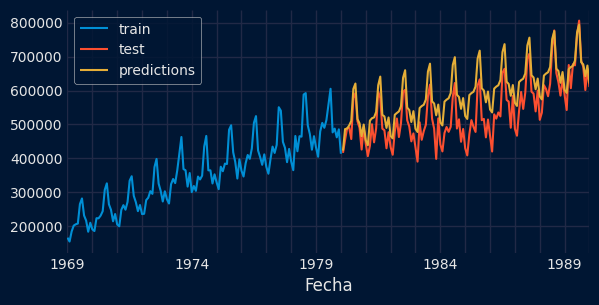

In [71]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [72]:
# Prediction error
# ==============================================================================
error_mse = mean_absolute_error(y_true=data_test, y_pred=predictions)
print(f"Test error (mse): {error_mse}")

Test error (mse): 55746.18180016704


## Prediction intervals

The method `predict_interval` enables the calculation of prediction intervals for the forecasted values. Users can specify the confidence level of the estimated interval using either the `alpha` or `interval` argument.

In [44]:
# Prediction intervals
# ==============================================================================
predictions = forecaster.predict_interval(steps=36, alpha=0.05)
predictions.head(5)

,pred,lower_bound,upper_bound
1980-02-01,422810.037200,393266.200267,452353.874133
1980-03-01,486540.779353,453312.820956,519768.737751
1980-04-01,487966.586748,453162.540290,522770.633206
1980-05-01,497237.801421,460260.590289,534215.012554
1980-06-01,510519.468024,471780.235828,549258.700220


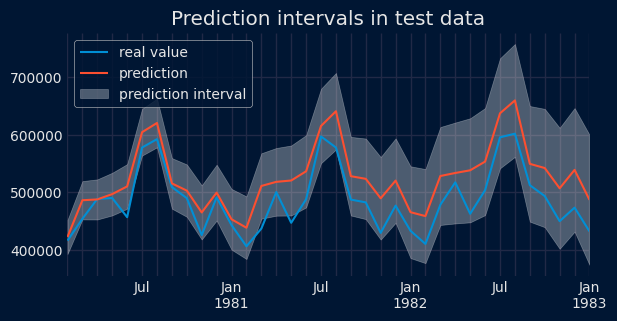

In [45]:
# Plot prediction intervals
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
plot_prediction_intervals(
    predictions         = predictions,
    y_true              = data_test,
    target_variable     = "y",
    title               = "Prediction intervals in test data",
    kwargs_fill_between = {'color': 'white', 'alpha': 0.3, 'zorder': 1},
    ax                  = ax
)

## Feature importances

The method `get_feature_importances` returns the coefficients of the model, which can be used as a measure of feature importance.

In [46]:
# Feature importances
# ==============================================================================
forecaster.get_feature_importances()

,feature,importance
0,sar1,-0.335019
1,sma1,-0.358271
2,ma1,-0.417191
3,ar1,-0.439953


## Backtesting

One of the advantages of encapsulating statistical models within the `ForecasterStats` class is that they can be evaluated using any of the [backtesting strategies](../introduction-forecasting/introduction-forecasting.html#backtesting-forecasting-models) strategies implemented in skforecast.

<div role="note"
    style="background: rgba(0,184,212,.08); border-left: 6px solid #00b8d4;
          border-radius: 6px; padding: 10px 12px; margin: 1em 0;">

<p style="display:flex; align-items:center; font-size:1rem; color:#00b8d4;
          margin:0 0 6px 0; font-weight:400;">
  <span style="margin-right:6px; font-size:18px;">✏️</span>
  <strong style="font-size:18px;">Note</strong>
</p>

<p style="margin:0; color:inherit;">
Due to their mathematical formulation, most statistical models require predictions to be made contiguously from the end of the training data. Consequently, these estimators generally require a refit in each backtesting fold to incorporate new observations and update their internal state.

Because refitting is mandatory for these models, the Numba-optimized backend of skforecast becomes its most valuable asset here. It allows for hundreds of refits during backtesting in a fraction of the time required by non-optimized libraries.
</p>

</div>

In [47]:
# Backtest forecaster
# ======================================================================================
forecaster = ForecasterStats(estimator=Arima(order=(1, 1, 1), seasonal_order=(1, 1, 1), m=12))

cv = TimeSeriesFold(
         steps              = 12,  # predict 12 month per fold
         initial_train_size = len(data_train),
         refit              = True,
         fixed_train_size   = False,
     )

metric, predictions = backtesting_stats(
                          forecaster        = forecaster,
                          y                 = data,
                          cv                = cv,
                          metric            = 'mean_absolute_error',
                          n_jobs            = 'auto',
                          suppress_warnings = True,
                          verbose           = True,
                          show_progress     = True
                      )
metric

Information of folds
--------------------
Number of observations used for initial training: 133
Number of observations used for backtesting: 120
    Number of folds: 10
    Number skipped folds: 0 
    Number of steps per fold: 12
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0

Fold: 0
    Training:   1969-01-01 00:00:00 -- 1980-01-01 00:00:00  (n=133)
    Validation: 1980-02-01 00:00:00 -- 1981-01-01 00:00:00  (n=12)
Fold: 1
    Training:   1969-01-01 00:00:00 -- 1981-01-01 00:00:00  (n=145)
    Validation: 1981-02-01 00:00:00 -- 1982-01-01 00:00:00  (n=12)
Fold: 2
    Training:   1969-01-01 00:00:00 -- 1982-01-01 00:00:00  (n=157)
    Validation: 1982-02-01 00:00:00 -- 1983-01-01 00:00:00  (n=12)
Fold: 3
    Training:   1969-01-01 00:00:00 -- 1983-01-01 00:00:00  (n=169)
    Validation: 1983-02-01 00:00:00 -- 1984-01-01 00:00:00  (n=12)
Fold: 4
    Training:   1969-01-01 00:00:00 -- 1984-01-01 00:00:00  (n=181)
    Validation: 1984-02

  0%|          | 0/10 [00:00<?, ?it/s]

,mean_absolute_error
0,19298.471843


In [48]:
# Backtest predictions
# ======================================================================================
predictions.head(4)

,fold,pred
1980-02-01,0,422810.037200
1980-03-01,0,486540.779353
1980-04-01,0,487966.586748
1980-05-01,0,497237.801421


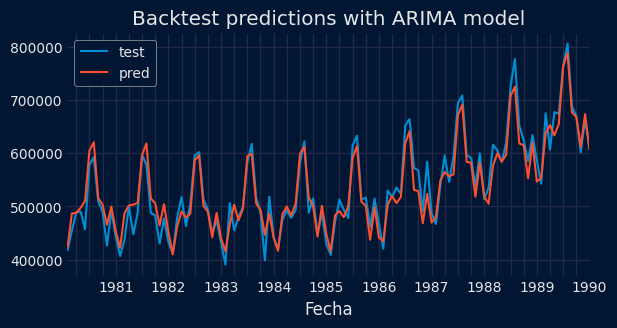

In [49]:
# Plot backtest predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
data.loc[end_train:].plot(ax=ax, label='test')
predictions['pred'].plot(ax=ax)
ax.set_title('Backtest predictions with ARIMA model')
ax.legend();

## Model tunning (p, d, q)

To find the optimal hyperparameters for statistical models, two approaches are widely used

+ **Statistical Criteria**: Information criteria, such as Akaike's Information Criterion (AIC) or Bayesian Information Criterion (BIC), apply different penalties to the maximum likelihood (log-likelihood) estimate to measure model fit. The advantage of these criteria is that they are computed solely on the training data, eliminating the need for out-of-sample predictions. Consequently, the optimization process is significantly accelerated. The well-known AutoArima and AutoETS algorithms use this approach.

+ **Validation Techniques**: Utilizing validation techniques, [backtesting](../user_guides/hyperparameter-tuning-and-lags-selection.html), is another effective strategy. Backtesting evaluates model performance using independent partitions of historical data to simulate real-world conditions. This provides a practical assessment of how hyperparameters perform across different time windows.


In the first approach, calculations are based solely on training data, eliminating the need for a separate data partition. This makes the optimization process extremely efficient. However, it is important to note that information criteria only measure the relative quality of models within the defined search space. A model with the lowest AIC could still be a poor fit in absolute terms. Therefore, the selected model should ideally undergo a backtesting phase. This phase calculates forecast error metrics (such as MAE, MSE, or MAPE) to validate performance on a meaningful, interpretable scale.

### AutoArima

**AutoArima** is an algorithm designed to automate the selection of optimal hyperparameters for an ARIMA model. The algorithm systematically evaluates various combinations of non-seasonal parameters ($p, d, q$), seasonal parameters ($P, D, Q$), and the seasonal period ($m$) to identify the configuration that best fits the data based on a specified criterion, typically the Akaike Information Criterion (AIC) or Bayesian Information Criterion (BIC).

Skforecast's [Arima](./forecasting-sarimax-arima.html) class triggers the AutoArima functionality whenever the `order` or `seasonal_order` arguments are set to `None`. After the model is fitted, the optimal parameters can be accessed via the best_params_ attribute. For all subsequent predictions, the model automatically utilizes the optimal configuration identified during the fitting process. This functionality is also available in the [Ets](./forecasting-ets.html) when `model` is set to `None` or to `ZZZ`.

In [52]:
# Skforecast Auto Arima
# ==============================================================================
auto_arima = Arima(
        order=None,
        seasonal_order=None,
        start_p=0,
        start_q=0,
        max_p=12,
        max_q=3,
        max_P=2,
        max_Q=2,
        max_order=5,
        max_d=2,
        max_D=1,
        ic="aic",
        m=12,
        trace=True,  # True for detailed information of the process
    )
forecaster = ForecasterStats(estimator=auto_arima)
forecaster.fit(y=data_train, suppress_warnings=True)

 ARIMA(0,0,0)(1,1,1)[12] with drift         : 2705.6134
 ARIMA(0,0,0)(0,1,0)[12] with drift         : 2742.4671
 ARIMA(1,0,0)(1,1,0)[12] with drift         : 2711.7695
 ARIMA(0,0,1)(0,1,1)[12] with drift         : 2705.5029
 ARIMA(0,0,0)(0,1,0)[12]                    : 2871.9907
 ARIMA(0,0,1)(0,1,0)[12] with drift         : 2743.9402
 ARIMA(0,0,1)(1,1,1)[12] with drift         : 2704.7817
 ARIMA(0,0,1)(1,1,1)[12]                    : Inf
 ARIMA(0,0,1)(1,1,0)[12] with drift         : 2712.8494
 ARIMA(0,0,1)(2,1,1)[12] with drift         : Inf
 ARIMA(0,0,1)(1,1,2)[12] with drift         : Inf
 ARIMA(0,0,1)(0,1,2)[12] with drift         : 2702.3991
 ARIMA(0,0,1)(0,1,2)[12]                    : Inf
 ARIMA(0,0,0)(0,1,2)[12] with drift         : Inf
 ARIMA(1,0,1)(0,1,2)[12] with drift         : Inf
 ARIMA(0,0,2)(0,1,2)[12] with drift         : 2679.3956
 ARIMA(0,0,2)(0,1,2)[12]                    : Inf
 ARIMA(0,0,2)(0,1,1)[12] with drift         : 2686.4991
 ARIMA(0,0,2)(1,1,2)[12] with drif

<div class="admonition note" name="html-admonition" style="background: rgba(255,145,0,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #ff9100; border-color: #ff9100; padding-left: 10px; padding-right: 10px">

<p class="title">
    <i style="font-size: 18px; color:#ff9100; border-color: #ff1744;"></i>
    <b style="color: #ff9100;"> <span style="color: #ff9100;">&#9888;</span> Warning</b>
</p>

When evaluating ARIMA-SARIMAX models, it is important to note that AIC assumes that all models are trained on the same data. Thus, using AIC to decide between different orders of differencing is technically invalid, since one data point is lost with each order of differencing. Therefore, the Auto Arima algorithm uses a unit root test to select the order of differencing, and only uses the AIC to select the order of the AR and MA components.

For a detailed explanation of Akaike's Information Criterion (AIC) see <a href="https://robjhyndman.com/hyndsight/aic/">Rob J Hyndman's blog</a> and <a href="https://sites.warnercnr.colostate.edu/kenburnham/wp-content/uploads/sites/25/2016/08/AIC-Myths-and-Misunderstandings.pdf">AIC Myths and Misunderstandings by Anderson and Burnham</a>.

</div>

### Grid search with backtesting

Although less common in the context of statistical models, it is also possible to use grid search and random search to find optimal hyperparameters. It is crucial to conduct the search using a validation dataset, rather than the test dataset, to ensure an accurate and unbiased evaluation of model performance.

The training partition is split again to separate a validation partition, which is used for the hyperparameter search. The test partition remains untouched and is reserved exclusively for the final evaluation of the model's performance.

In [60]:
# Split Train-validation-test data
# ======================================================================================
end_train = '1976-01-01 23:59:59'
end_val   = '1980-01-01 23:59:59'
print(
    f"Train dates      : {data.index.min()} --- {data.loc[:end_train].index.max()}  "
    f"(n={len(data.loc[:end_train])})"
)
print(
    f"Validation dates : {data.loc[end_train:].index.min()} --- {data.loc[:end_val].index.max()}  "
    f"(n={len(data.loc[end_train:end_val])})"
)
print(
    f"Test dates       : {data.loc[end_val:].index.min()} --- {data.index.max()}  "
    f"(n={len(data.loc[end_val:])})"
)

Train dates      : 1969-01-01 00:00:00 --- 1976-01-01 00:00:00  (n=85)
Validation dates : 1976-02-01 00:00:00 --- 1980-01-01 00:00:00  (n=48)
Test dates       : 1980-02-01 00:00:00 --- 1990-01-01 00:00:00  (n=120)


In [61]:
# Grid search hyperparameter
# ======================================================================================
forecaster = ForecasterStats(
                 estimator=Arima(order=(0, 0, 0))  # Placeholder replaced in the grid search
             )

param_grid = {
    'order': [(0, 1, 0), (0, 1, 1), (1, 1, 0), (1, 1, 1), (2, 1, 1)],
    'seasonal_order': [(0, 0, 0,), (0, 1, 0), (1, 1, 1)],
    'm': [1, 12]
}

cv = TimeSeriesFold(steps=12, initial_train_size=len(data.loc[:end_train]))

results_grid = grid_search_stats(
                   forecaster        = forecaster,
                   y                 = data.loc[:end_val],
                   param_grid        = param_grid,
                   cv                = cv,
                   metric            = 'mean_absolute_error',
                   return_best       = True,
                   n_jobs            = 'auto',
                   suppress_warnings = True,
                   verbose           = False,
                   show_progress     = True
               )
results_grid.head(5)

Number of models compared: 30.


params grid:   0%|          | 0/30 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found parameters, and the whole data set: 
  Parameters: {'m': 12, 'order': (0, 1, 1), 'seasonal_order': (1, 1, 1)}
  Backtesting metric: 15197.495835661879



,params,mean_absolute_error,m,order,seasonal_order
0,"{'m': 12, 'order': (0, 1, 1), 'seasonal_order'...",15197.495836,12,"(0, 1, 1)","(1, 1, 1)"
1,"{'m': 12, 'order': (1, 1, 1), 'seasonal_order'...",15721.865857,12,"(1, 1, 1)","(1, 1, 1)"
2,"{'m': 12, 'order': (1, 1, 0), 'seasonal_order'...",16026.667320,12,"(1, 1, 0)","(1, 1, 1)"
3,"{'m': 12, 'order': (0, 1, 0), 'seasonal_order'...",16703.697810,12,"(0, 1, 0)","(1, 1, 1)"
4,"{'m': 12, 'order': (0, 1, 1), 'seasonal_order'...",19466.092522,12,"(0, 1, 1)","(0, 1, 0)"


Since `return_best = True`, the Forecaster object is updated with the most optimal configuration found and trained with the entire dataset. This means that the grid search will yield the lowest error model with the best hyperparameters that lead to the highest performance metric. This last model can subsequently be utilized for forecasts on new data.

## Multiple estimators

`ForecasterStats` allows for the use of multiple statistical estimators, enabling simultaneous training and prediction across all of them. By predicting simultaneously, skforecast ensures that all models are evaluated on the exact same time coordinates and exogenous data, eliminating the risk of "alignment errors" that often occur when comparing results from different libraries manually.

Furthermore, it has been well-proven that forecasting accuracy can be increased by combining the predictions of multiple statistical models (ensembling) rather than relying on a single one.

In [73]:
# Forecaster with multiple statistical models as estimators
# ==============================================================================
estimators = [
    Arima(order=(1, 1, 1), seasonal_order=(1, 1, 1), m=12),
    Ets(m=12, model="MAM"),
    Arar()
]
forecaster = ForecasterStats(estimator=estimators)
forecaster.fit(y=data_train, suppress_warnings=False)
forecaster

c:\Users\Joaquin\miniconda3\envs\skforecast_20_py13\Lib\site-packages\skforecast\stats\arima\_arima_base.py:2512: UserWarning: Possible convergence problem.Try to increase 'maxiter' or change the optimization method.
  warnings.warn(


=============== 
ForecasterStats 
=============== 
Estimators: ['skforecast.Arima', 'skforecast.Ets', 'skforecast.Arar'] 
Series name: y 
Exogenous included: False 
Exogenous names: None 
Transformer for y: None 
Transformer for exog: None 
Training range: [Timestamp('1969-01-01 00:00:00'), Timestamp('1980-01-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Estimator parameters: 
    skforecast.Arima: 
        {'order': (1, 1, 1), 'seasonal_order': (1, 1, 1), 'm': 12, 'include_mean':
        True, 'transform_pars': True, 'method': 'CSS-ML', 'n_cond': None,
        'SSinit': 'Gardner1980', 'optim_method': 'BFGS', 'optim_kwargs':
        {'maxiter': 1000}, 'kappa': 1000000.0}
    skforecast.Ets: 
        {'m': 12, 'model': 'MAM', 'damped': None, 'alpha': None, 'beta': None,
        'gamma': None, 'phi': None, 'seasonal': True, 'trend': None,
        'allow_multiplicative': True, 'allow_multiplicative_trend': False}
    skforecast.Arar: {'max_ar_depth': 26, 'max_lag': 40, 'safe': True} 
fit_kwargs: None 
Creation date: 2026-01-30 10:14:03 
Last fit date: 2026-01-30 10:14:03 
Index seen by the forecaster: DatetimeIndex(['1969-01-01', '1969-02-01', '1969-03-01', '1969-04-01',
               '1969-05-01', '1969-06-01', '1969-07-01', '1969-08-01',
               '1969-09-01', '1969-10-01',
               ...
               '1979-04-01', '1979-05-01', '1979-06-01', '1979-07-01',
               '1979-08-01', '1979-09-01', '1979-10-01', '1979-11-01',
               '1979-12-01', '1980-01-01'],
              dtype='datetime64[ns]', name='Fecha', length=133, freq='MS') 
Skforecast version: 0.20.0 
Python version: 3.13.11 
Forecaster id: None

In [74]:
# Prediction with multiple estimators
# ==============================================================================
predictions = forecaster.predict(steps=len(data_test))
predictions.head(6)

,estimator_id,pred
1980-02-01,skforecast.Arima,422810.037200
1980-02-01,skforecast.Ets,417768.193042
1980-02-01,skforecast.Arar,417947.645080
1980-03-01,skforecast.Arima,486540.779353
1980-03-01,skforecast.Ets,485992.080365
1980-03-01,skforecast.Arar,498325.568939


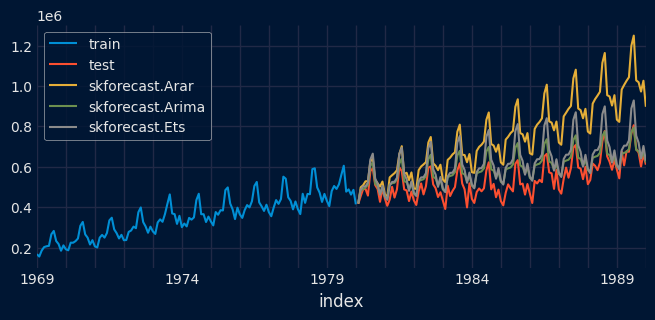

In [75]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
(
    predictions
    .reset_index()
    .pivot(index='index', columns='estimator_id', values='pred')
    .plot(ax=ax)
)
ax.legend();

ForecasterStats assigns a unique identifier and a name to each model passed as an estimator. While the IDs remain constant to ensure consistent tracking, if AutoArima or AutoETS is triggered, the names are automatically updated after fitting to reflect the specific parameters of the selected estimators.

In [76]:
print(f"Estimators id: {forecaster.estimator_ids}")
print(f"Estimators names: {forecaster.estimator_names_}")

Estimators id: ['skforecast.Arima', 'skforecast.Ets', 'skforecast.Arar']
Estimators names: ['Arima(1,1,1)(1,1,1)[12]', 'Ets(MAM)', 'Arar(lags=(1, 2, 12, 13))']


A detailed summary of all estimators included in the forecaster can be accessed using the `get_estimators_info()` method.

In [77]:
# Information of the estimators included in the forecaster
# ==============================================================================
forecaster.get_estimators_info()

,id,name,type,supports_exog,supports_interval,params
0,skforecast.Arima,"Arima(1,1,1)(1,1,1)[12]",skforecast.stats._arima.Arima,True,True,"{'order': (1, 1, 1), 'seasonal_order': (1, 1, ..."
1,skforecast.Ets,Ets(MAM),skforecast.stats._ets.Ets,False,True,"{'m': 12, 'model': 'MAM', 'damped': None, 'alp..."
2,skforecast.Arar,"Arar(lags=(1, 2, 12, 13))",skforecast.stats._arar.Arar,True,True,"{'max_ar_depth': 26, 'max_lag': 40, 'safe': True}"


Other methods that allow for the access and manipulation of estimators include `get_estimator()`, `remove_estimators()`, and `set_params()`.

## Exogenous variables

Exogenous variables can be incorporated into the model using the `exog` argument. The primary requirement for including an exogenous variable is that its values must be known for both the training period and the entire forecast horizon.

<div class="admonition note" name="html-admonition" style="background: rgba(0,191,191,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00bfa5; border-color: #00bfa5; padding-left: 10px; padding-right: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#00bfa5;"></i>
    <b style="color: #00bfa5;">&#128161 Tip</b>
</p>

To learn more about exogenous variables and how to correctly manage them with skforecast visit: <a href="../user_guides/exogenous-variables.html">Exogenous variables (features) user guide</a>.

</div>

In [ ]:
# Create caledar features to be used as exogenous variables
# ==============================================================================
exog = pd.DataFrame(
            {'month': data.index.month},
            index = data.index
        )
exog_train = exog.loc[:end_train]
exog_test  = exog.loc[end_train:]
exog.head()

,month
Fecha,
1969-01-01,1
1969-02-01,2
1969-03-01,3
1969-04-01,4
1969-05-01,5


In [ ]:
# Create and fit ForecasterStats with exogenous variables
# ==============================================================================
forecaster = ForecasterStats(
                 estimator=Arima(order=(1, 1, 1), seasonal_order=(1, 1, 1), m=12),
             )
forecaster.fit(
    y                 = data_train, 
    exog              = exog_train,
    suppress_warnings = True
)

# Predict with exog
# ==============================================================================
predictions = forecaster.predict(
                  steps = 36,
                  exog  = exog_test
              )
predictions.head(3)

1980-02-01    422830.111044
1980-03-01    486551.956458
1980-04-01    487965.470081
Freq: MS, Name: pred, dtype: float64

## Prediction on training data (In-sample Predictions)

Predictions on the training data are crucial for evaluating the accuracy and effectiveness of the model. By comparing the predicted values wtih the actual observed values in the training dataset, you can assess how well the model has learned the underlying patterns and trends in the data. This comparison helps in understanding the model's performance and identify areas where it may need improvement or adjustment. In essence, they act as a mirror, reflecting how the model interprets and reconstructs the historical data on which it was trained.

Predictions of the observatios used to fit the mode are stored in the `fitted_values_` attribute of the `Arima` object.

In [ ]:
# Create and fit ForecasterStats (skforecast)
# ==============================================================================
forecaster = ForecasterStats(
                 estimator=Arima(order=(1, 1, 1), seasonal_order=(1, 1, 1), m=12),
             )
forecaster.fit(y=data_train, suppress_warnings=True)

# In-sample Predictions
# ==============================================================================
# Show only the first 5 values 
forecaster.estimators_[0].fitted_values_[:5]

array([166778.86748393, 155441.28198692, 184949.38956863, 202282.72293643,
       206228.03031053])